In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
from sklearn.model_selection import train_test_split
import random
import re
import pdb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
np.random.seed(42)
from lifelines.utils import concordance_index

from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test
# import pandas_profiling

## Stratified C-index definition

In [ ]:
def stratified_cscore(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """

    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'

    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

In [22]:
df_train = pd.read_csv('data/train.csv', index_col='ID')
df_test = pd.read_csv('data/test.csv', index_col='ID')
data_description = pd.read_csv('data/data_dictionary.csv')

In [23]:
print(df_train.columns)
df_train.head(5)

Index(['dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high',
 

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
ID,,,,,,,,,,,,,,,,,,,,,
0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


## feature to sample ratio

In [24]:
print(df_train.shape, df_train.shape[1]/df_train.shape[0])

(28800, 59) 0.0020486111111111113


In [25]:
skim(df_train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 28800  │ │ string      │ 35    │                                                          │
│ │ Number of columns │ 59     │ │ float64     │ 23    │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA    ┃ NA %   ┃ mean  ┃ sd    ┃ p0     ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ hla_match_c_high        │  4620 │  16.04 │   1.8 │  0.43 │      0 │     2 │     2 │     2 │     2 │    ▂ ▇ │  │
│ │ hla_high_res_8          │  5829 │  20.24 │   6.9 │   1.6 │      2 │     6 │     8 │     8 │     8 │   ▂▁▁▇ │  │
│ │ hla_low_res_6           │  3270 │  11.35 │   5.1 │   1.2 │      2 │     4 │     6 │     6 │     6 │  ▃ ▁▁▇ │  │
│ │ hla_high_res_6          │  5284 │  18.35 │   5.1 │   1.2 │      0 │     4 │     6 │     6 │     6 │    ▂▁▇ │  │
│ │ hla_high_res_10         │  7163 │  24.87 │   8.6 │   1.9 │      3 │     7 │    10 │    10 │    10 │  ▂▁▁▁▇ │  │
│ │ hla_match_dqb1_high     │  5199 │  18.05 │   1.7 │  0.45 │      0 │     1 │     2 │     2 │     2 │    ▃ ▇ │  │
│ │ hla_nmdp_6              │  4197 │  14.57 │   5.2 │   1.2 │      2 │     4 │     6 │     6 │     6 │  ▃ ▁▂▇ │  │
│ │ hla_match_c_low         │  2800 │   9.72 │   1.8 │  0.44 │      0 │     2 │     2 │     2 │     2 │    ▂ ▇ │  │
│ │ hla_match_drb1_low      │  2643 │   9.18 │   1.7 │  0.45 │      1 │     1 │     2 │     2 │     2 │ ▃    ▇ │  │
│ │ hla_match_dqb1_low      │  4194 │  14.56 │   1.8 │  0.43 │      0 │     2 │     2 │     2 │     2 │    ▂ ▇ │  │
│ │ year_hct                │     0 │      0 │  2000 │   3.2 │   2000 │  2000 │  2000 │  2000 │  2000 │ ▂▁▃▃▇▇ │  │
│ │ hla_match_a_high        │  4301 │  14.93 │   1.7 │  0.46 │      0 │     1 │     2 │     2 │     2 │    ▃ ▇ │  │
│ │ donor_age               │  1808 │   6.28 │    43 │    15 │     18 │    28 │    40 │    56 │    85 │ ▇▇▅▆▃  │  │
│ │ hla_match_b_low         │  2565 │   8.91 │   1.7 │  0.45 │      0 │     1 │     2 │     2 │     2 │    ▃ ▇ │  │
│ │ age_at_hct              │     0 │      0 │    39 │    21 │  0.044 │    20 │    41 │    56 │    74 │ ▆▃▅▆▇▆ │  │
│ │ hla_match_a_low         │  2390 │    8.3 │   1.7 │  0.46 │      0 │     1 │     2 │     2 │     2 │    ▃ ▇ │  │
│ │ hla_match_b_high        │  4088 │  14.19 │   1.7 │  0.47 │      0 │     1 │     2 │     2 │     2 │    ▃ ▇ │  │
│ │ comorbidity_score       │   477 │   1.66 │   1.7 │     2 │      0 │     0 │     1 │     2 │    10 │  ▇▅▁▁  │  │
│ │ karnofsky_score         │   870 │   3.02 │    84 │    11 │     40 │    70 │    90 │    90 │   100 │   ▁▃▁▇ │  │
│ │ hla_low_res_8           │  3653 │  12.68 │   6.9 │   1.6 │      2 │     6 │     8 │     8 │     8 │   ▂▁▁▇ │  │
│ │ hla_match_drb1_high     │  3352 │  11.64 │   1.7 │  0.46 │      0 │     1 │     2 │     2 │     2 │    ▃ ▇ │  │
│ │ hla_low_res_10          │  5064 │  17.58 │   8.7 │  

## Mode imputation for missing data

In [26]:
print("before imputation:", sum(df_train.isna().sum()))
mode_values = df_train.mode().iloc[0]
df_train.fillna(mode_values, inplace=True)
print("after imputation:", sum(df_train.isna().sum()))

before imputation: 189575
after imputation: 0


In [27]:
df_train['race_group'].value_counts()

race_group
More than one race                           4845
Asian                                        4832
White                                        4831
Black or African-American                    4795
American Indian or Alaska Native             4790
Native Hawaiian or other Pacific Islander    4707
Name: count, dtype: int64

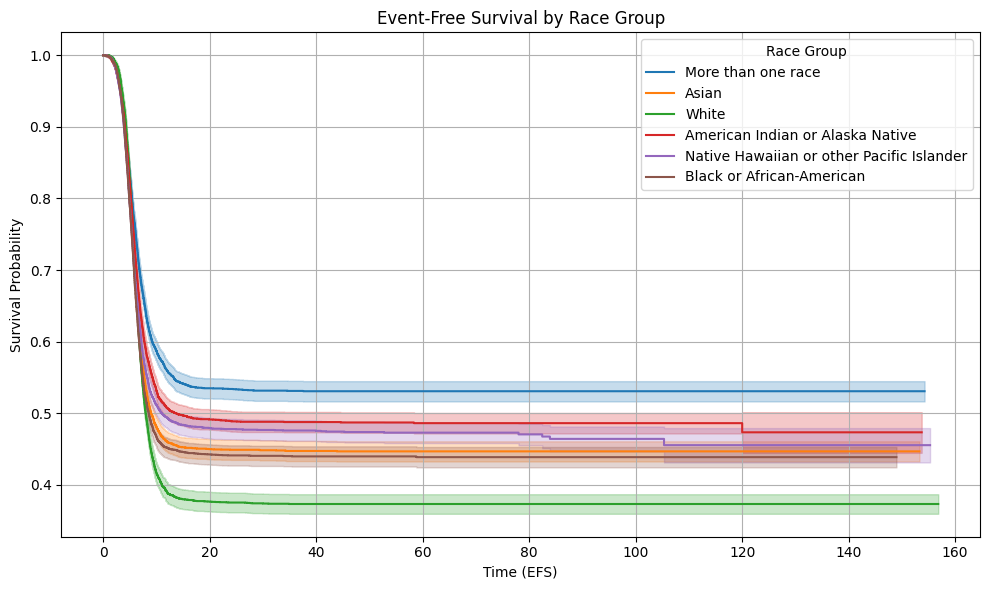

In [28]:
event_column = 'efs'
time_column = 'efs_time'
race_column = 'race_group'
race_groups = df_train[race_column].unique()
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Adjust figure size for better readability

for race in race_groups:
    subset = df_train[df_train[race_column] == race]
    T = subset[time_column]
    E = subset[event_column]
    kmf.fit(T, event_observed=E, label=race)
    kmf.plot(ax=plt.gca())  # Plot on the current axes

plt.title('Event-Free Survival by Race Group')
plt.xlabel('Time (EFS)')
plt.ylabel('Survival Probability')
plt.grid(True)  # Add a grid for better readability
plt.legend(title='Race Group')  # Add a legend with a title
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Perform Log-Rank Test (pairwise comparison)
# Compare all pairs of race groups
for i in range(len(race_groups)):
    for j in range(i + 1, len(race_groups)):
        group1 = race_groups[i]
        group2 = race_groups[j]

        subset1 = df_train[df_train[race_column] == group1]
        subset2 = df_train[df_train[race_column] == group2]

        T1 = subset1[time_column]
        E1 = subset1[event_column]
        T2 = subset2[time_column]
        E2 = subset2[event_column]

        # results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
        # print(f"Log-Rank Test: {group1} vs {group2}")
        # results.print_summary()
        # print("\n")

## categorical encoding

In [29]:
# Categorical & Numeric columns 
cat_cols = []
num_cols = []
for v, t in data_description[['variable', 'type']].values:
    if t == 'Categorical' and v != 'efs':
        cat_cols.append(v)
    elif not v in ['efs_time', 'efs']:
        num_cols.append(v)

In [40]:
# cat_cols + num_cols
df_train['year_hct'].head()

ID
0    2016
1    2008
2    2019
3    2009
4    2018
Name: year_hct, dtype: int64

In [33]:
df_train[cat_cols] = df_train[cat_cols].astype('category')

## Visualization

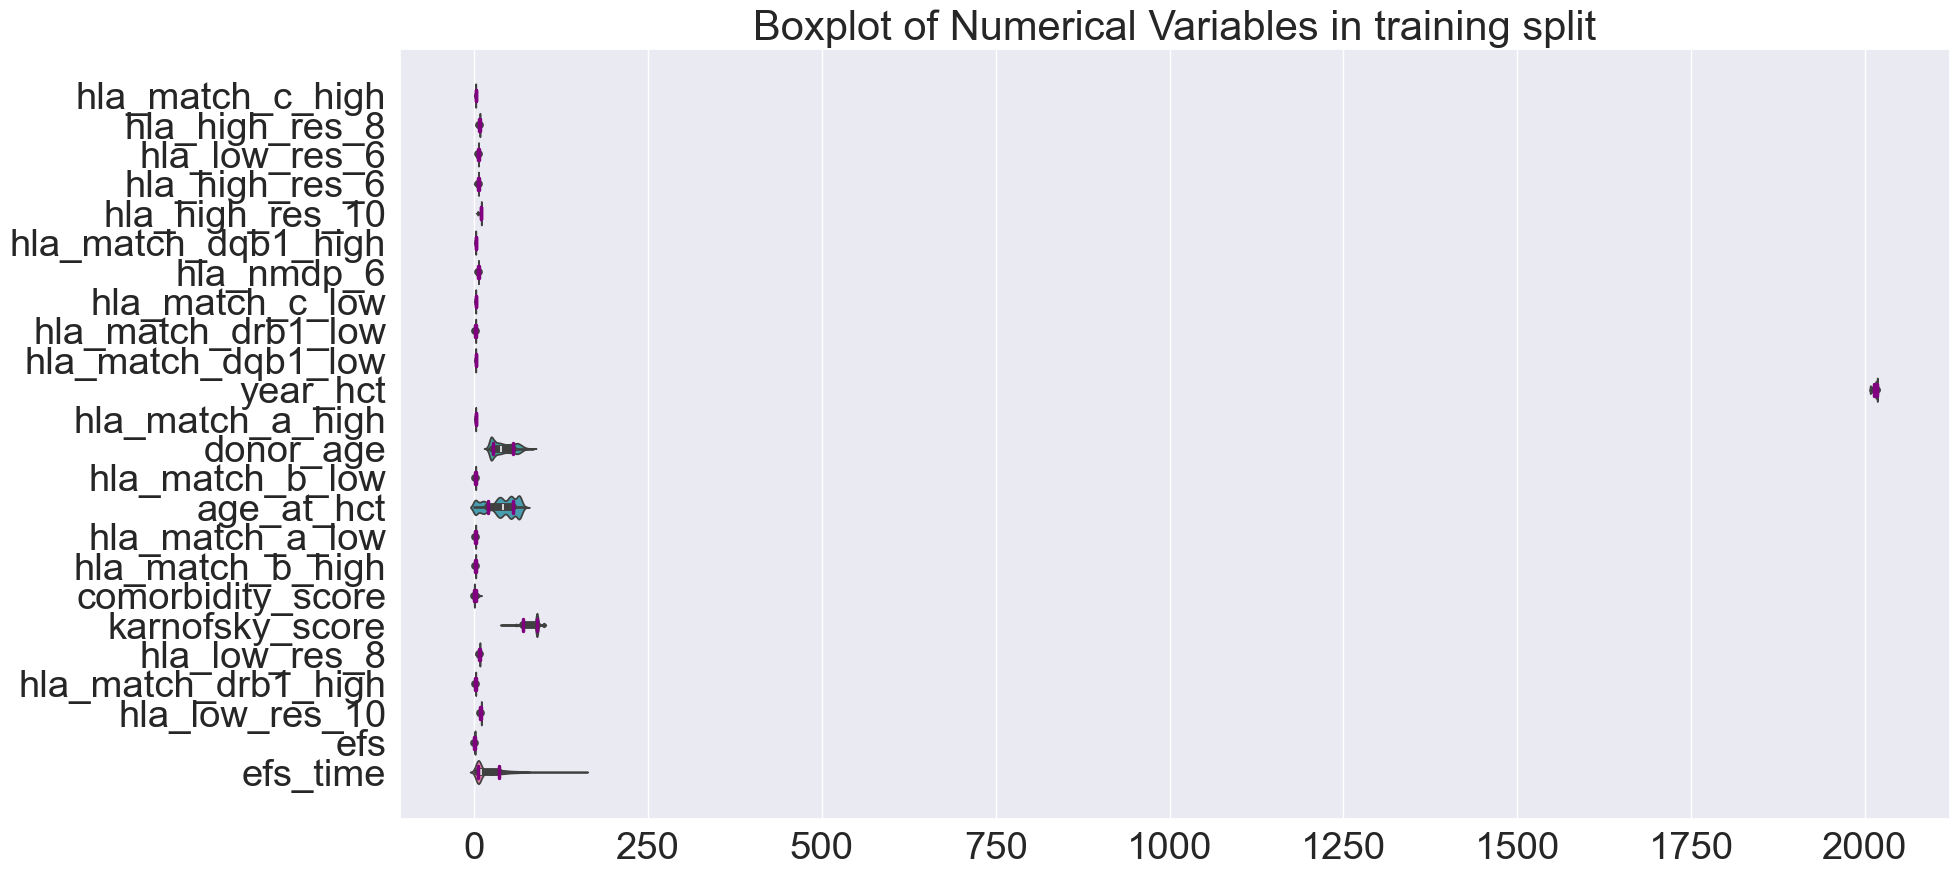

In [41]:
# Select numerical variables for boxplot
numerical_vars = df_train.select_dtypes(include=['float64', 'int64'])
# numerical_vars = df_train['year_hct']
sns.set_theme(font_scale=2.5) 
# Plot boxplot for each numerical variable
plt.figure(figsize=(20, 10))
violin = sns.violinplot(data=numerical_vars, orient='h')
# Calculate IQR values
Q1 = numerical_vars.quantile(0.25)
Q3 = numerical_vars.quantile(0.75)
IQR = Q3 - Q1

for i, col in enumerate(numerical_vars.columns):
    Q1 = numerical_vars[col].quantile(0.25)
    Q3 = numerical_vars[col].quantile(0.75)
    IQR = Q3 - Q1
    
    plt.plot([Q1, Q1], [i-0.2, i+0.2], color='purple', linestyle='-', linewidth=2.5)
    plt.plot([Q3, Q3], [i-0.2, i+0.2], color='purple', linestyle='-', linewidth=2.5)
    

plt.title('Boxplot of Numerical Variables in training split')
plt.show()


## Preprocessing
### Year of HCT: Subtract from baseline to avoid 2000 scale

In [42]:
# Define the baseline year (e.g., the minimum year in the dataset)
baseline_year = df_train['year_hct'].min()

# Convert year to years since baseline
df_train['year_hct_relative'] = df_train['year_hct'] - baseline_year

df_train.drop(columns=['year_hct'], inplace=True)


In [44]:
# # Select numerical variables for boxplot
# numerical_vars = df_train.select_dtypes(include=['float64', 'int64'])
# # numerical_vars = df_train['year_hct']
# sns.set_theme(font_scale=2.5) 
# # Plot boxplot for each numerical variable
# plt.figure(figsize=(20, 10))
# violin = sns.violinplot(data=numerical_vars, orient='h')
# # Calculate IQR values
# Q1 = numerical_vars.quantile(0.25)
# Q3 = numerical_vars.quantile(0.75)
# IQR = Q3 - Q1

# for i, col in enumerate(numerical_vars.columns):
#     Q1 = numerical_vars[col].quantile(0.25)
#     Q3 = numerical_vars[col].quantile(0.75)
#     IQR = Q3 - Q1
    
#     plt.plot([Q1, Q1], [i-0.2, i+0.2], color='purple', linestyle='-', linewidth=2.5)
#     plt.plot([Q3, Q3], [i-0.2, i+0.2], color='purple', linestyle='-', linewidth=2.5)
    

# plt.title('Boxplot of Numerical Variables in training split')
# plt.show()


### Target preprocessing using Kaplan filter

In [46]:
naf = NelsonAalenFitter()
naf.fit(df_train['efs_time'], df_train['efs'])
df_train['naf_label'] = -naf.cumulative_hazard_at_times(df_train['efs_time']).values
# df_train.loc[df_train['efs'] == 0, 'naf_label'] -= 0.1

kmf = KaplanMeierFitter()
kmf.fit(df_train['efs_time'], df_train['efs'])
df_train['km_label'] = kmf.survival_function_at_times(df_train['efs_time']).values
# df_train.loc[df_train['efs'] == 0, 'km_label'] -= 0.1 